In [1]:
from fastai.tabular import *
from pathlib import Path

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


## Loading data 

In [3]:
train = Path('/kaggle/input/titanic/train.csv')
test = Path('/kaggle/input/titanic/test.csv')

train_data = pd.read_csv(train)
test_data = pd.read_csv(test)

## Feature Engineering

In [5]:
def process_title(df):
    title_dict = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Royalty"
    }
    
    df['Title'] = df['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    df['Title'] = df['Title'].map(title_dict)

    
def process_age(df):
    df_group = df.groupby(['Sex', 'Pclass', 'Title'])
    df['Age'] = df_group['Age'].apply(lambda x: x.fillna(x.median()))
    
def process_df(df):
    func_list = [process_title, process_age]

    for func in func_list:
        func(df)

## Processing data

In [6]:
process_df(train_data)
process_df(test_data)

In [7]:
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

## Checking the data to see if it seems valid

In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [9]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


## Setting dependent, categorical, and continuous variable

In [10]:
dep_var = 'Survived'
cat_var = train_data.drop(['Cabin', 'Name'], axis=1).select_dtypes(exclude='number').columns.tolist()
cont_var = train_data.drop('Survived', axis=1).select_dtypes(include='number').columns.tolist()
procs = [FillMissing, Categorify, Normalize]

In [11]:
print(cat_var)
print(cont_var)

['Sex', 'Ticket', 'Embarked', 'Title']
['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [12]:
test = TabularList.from_df(df=test_data.copy(), cat_names=cat_var, cont_names=cont_var, procs=procs)

## Creating databunch object for training

In [13]:
data = (TabularList.from_df(df=train_data.copy(), cat_names=cat_var, cont_names=cont_var, procs=procs)
                   .split_by_rand_pct(valid_pct=0.2, seed=42)
                   .label_from_df(cols=dep_var)
                   .add_test(test)
                   .databunch())

In [14]:
data.show_batch(rows=10)

Sex,Ticket,Embarked,Title,PassengerId,Pclass,Age,SibSp,Parch,Fare,target
male,S.C./A.4. 23567,S,Mr,-1.5623,0.8115,-0.2193,-0.4712,-0.4802,-0.4720,0
male,65303,S,Mr,0.0170,0.8115,-0.2193,0.3794,-0.4802,-0.2426,0
male,384461,Q,Mr,-0.7259,0.8115,-0.2193,-0.4712,-0.4802,-0.4778,0
male,A/5 3902,S,Mr,0.5655,0.8115,1.3428,-0.4712,-0.4802,-0.4874,0
male,350052,S,Mr,-0.2008,0.8115,-0.5169,-0.4712,-0.4802,-0.4769,0
female,PC 17761,C,Miss,0.3516,-1.6145,0.0782,-0.4712,-0.4802,1.4221,1
male,W./C. 14263,S,Mr,-0.7960,-0.4015,0.0038,-0.4712,-0.4802,-0.4248,0
male,C.A. 37671,S,Master,0.1649,0.8115,-1.4840,0.3794,0.7833,-0.3209,1
female,250655,S,Miss,-0.0763,-0.4015,-0.7401,-0.4712,-0.4802,-0.1264,1
male,A./5. 2152,S,Mr,-1.5934,0.8115,-0.5913,-0.4712,-0.4802,-0.4720,0


In [15]:
learn = tabular_learner(data, layers=[200, 100], metrics=accuracy, emb_drop=0.1)

## Finding model's learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


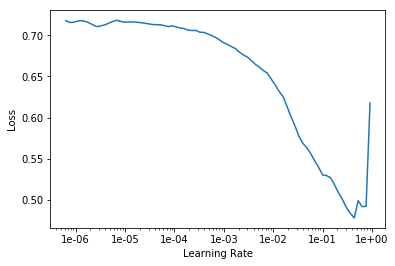

In [16]:
learn.lr_find()
learn.recorder.plot()

## Training the model

In [17]:
learn.fit_one_cycle(15, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.653282,0.682398,0.606742,00:00
1,0.602550,0.645470,0.837079,00:00
2,0.497484,0.486650,0.837079,00:00
3,0.370923,0.609315,0.837079,00:00
4,0.287750,0.608780,0.831461,00:00
5,0.230252,0.595873,0.820225,00:00
6,0.184319,0.701522,0.842697,00:00
7,0.148181,0.736031,0.842697,00:00
8,0.118838,0.743355,0.831461,00:00
9,0.098047,0.732351,0.831461,00:00


## Prediction

In [18]:
# Getting prediction
preds, targets = learn.get_preds(DatasetType.Test)
labels = [p.argmax().item() for p in preds]

# create submission
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': labels})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Thank you

thank you [Peter Begle](https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9) and [Sanjay.M](https://towardsdatascience.com/kaggle-titanic-machine-learning-model-top-7-fa4523b7c40) for the comprehensive feature engineering.
And thank you [Rakesh Dhotre](https://www.kaggle.com/rakeshvd/titanic-data-ml-fast-ai) for code guidance.